In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
import healpy as hp
import h5py
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
with h5py.File('better-comoving-positions.h5', 'r') as f:
    zs = array(f['zs'])
    ras = array(f['ras'])
    decs = array(f['decs'])

Here is what the detection pattern looks like on the sky:

Sigma is 1200.000000 arcmin (0.349066 rad) 
-> fwhm is 2825.784054 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


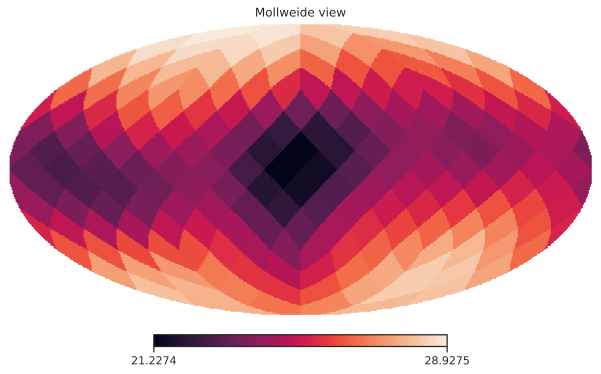

In [4]:
nside = 4
pixs = hp.ang2pix(nside, pi/2-decs, ras)
counts = bincount(pixs, minlength=hp.nside2npix(nside))
counts = hp.smoothing(counts, sigma=20*np.pi/180.0)
hp.mollview(counts)

In [5]:
dcs = Planck15.comoving_distance(zs).to(u.Gpc).value[:,newaxis]*column_stack((cos(ras)*cos(decs), sin(ras)*cos(decs), sin(decs)))
dcs = pd.DataFrame(data=dcs, columns=['x', 'y', 'z'])
nd = len(dcs)

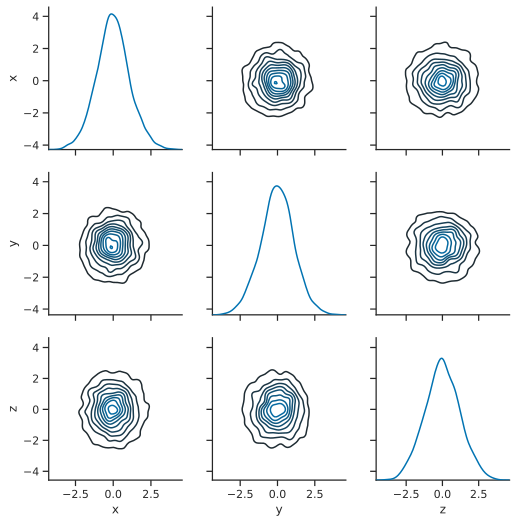

In [6]:
g = sns.PairGrid(dcs)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)

In [16]:
rmin = 50/1e3
rmax = 300/1e3
rbins = exp(arange(log(rmin), log(rmax), 0.05))

In [17]:
dd = DD(1, 1, rbins, dcs['x'], dcs['y'], dcs['z'])

In [18]:
Nrand = 25

ps = zeros((0, 3))
with h5py.File('better-comoving-positions-random.h5', 'r') as f:
    for i in range(Nrand):
        g = f[str(i)]
        z = array(g['zs'])
        r = array(g['ras'])
        d = array(g['decs'])

        p = Planck15.comoving_distance(z).to(u.Gpc).value[:,newaxis]*column_stack((cos(r)*cos(d), sin(r)*cos(d), sin(d)))
        ps = concatenate((ps, p), axis=0)

dr = DD(0, 1, rbins, dcs['x'], dcs['y'], dcs['z'], X2=ps[:,0], Y2=ps[:,1], Z2=ps[:,2])
rr = DD(1, 1, rbins, ps[:,0], ps[:,1], ps[:,2])

cf = convert_3d_counts_to_cf(len(dcs), len(dcs), ps.shape[0], ps.shape[0], dd, dr, dr, rr)

In [19]:
Gp = rr['npairs']/(ps.shape[0]*(ps.shape[0]-1)/2)
Exd = dd['npairs']/(len(dcs)*(len(dcs)-1)/2)/Gp
p = 2/(Gp*(len(dcs)*(len(dcs)-1)))

In [20]:
sigma_cf = Exd*sqrt(p)

In [21]:
rmids = 0.5*(rbins[1:] + rbins[:-1])

In [23]:
r_bao = 100/0.7/1000 # Gpc
w_bao = 15/0.7/1000 # Gpc
A_bao = 0.01

def xi_bao(r):
    return A_bao*exp(-0.5*square(r-r_bao)/(w_bao*w_bao))

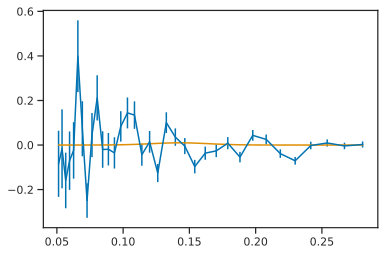

In [24]:
errorbar(rmids, cf, yerr=sigma_cf)
plot(rmids, xi_bao(rmids))